In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

## Resistance to Temperature Table

In [10]:
table = pd.read_csv("Temp-Resistance-Table.csv", dtype={'T':str}, index_col=0)
table.head()

,0,1,2,3,4,5,6,7,8,9
T,,,,,,,,,,
-200,18.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-190,22.83,22.40,21.97,21.54,21.11,20.68,20.25,19.82,19.38,18.95
-180,27.10,26.67,26.24,25.82,25.39,24.97,24.54,24.11,23.68,23.25
-170,31.34,30.91,30.49,30.07,29.64,29.22,28.80,28.37,27.95,27.52
-160,35.54,35.12,34.70,34.28,33.86,33.44,33.02,32.60,32.18,31.76


In [11]:
def find_t(n, data=table):
    """
    Given resistance n, look up temperature in the table
    """
    df_sub = data.sub(n).abs()
    loc = df_sub.min().idxmin(), df_sub.min(axis=1).idxmin()
    if loc[1][0] == "-":
        val = int(loc[1]) - int(loc[0])
    else:
        val = int(loc[1]) + int(loc[0])
        
    return val

print(find_t(0))
print(find_t(75))
print(find_t(99))
print(find_t(101))
print(find_t(150))


-200
-63
-3
3
99


## Superconductor Critical Temperature Plots

In [12]:
def analyze(txt, current=0.504, granularity=None, error=False):
    """"
    Given txt data file, calculate R and Temp
    Plot High Tc plots

    Ex data:
    SC_volt Divd_volt Divd_ratio Therm_R Ref_Volt
    0.0069377 4.6807050 0.9435667 33.1100273 4.9606513
    0.0095628 4.6784553 0.9426143 33.7027702 4.9632763  
    """
    
    trial = re.findall(r'\d+', txt)[-1]
    t = pd.read_csv(txt, sep=" ")

    # filter Therm_R > 1000
    d = t[t.Therm_R < 1000]

    #V = IR
    d['R'] = (d['SC_volt']-0.003)/current
    d['Temp'] = d['Therm_R'].apply(find_t) + 273.15

    ax = plt.gca()
    next_col = next(ax._get_lines.prop_cycler)['color']

    # Plotting
    plt.scatter(d['Temp'][::granularity], d['R'][::granularity], color=next_col, s=10)
    grad = np.gradient(d['R'])
    T_crit = d['Temp'][[np.where(grad==grad.max())][0][0][0]]
    print(f'TRIAL {trial}: Superconducting temperature derived from max gradient is {T_crit:.1f} K ({100*(T_crit-108)/108:.2f}%)')
    plt.axvline(T_crit, linestyle=':', color=next_col, label=f'T{trial} $T_C$ = {T_crit:.1f}K')

    if error:
        # uncertainties from experiment
        dV = 0.001875
        dI = 0.001
        d['error'] = abs(np.sqrt((dV/d['SC_volt'])**2 + (dI/current)**2)*d['R'])
        plt.errorbar(d['Temp'][::10], d['R'][::10], yerr=d['error'][::10], fmt='--', color='black', capsize=2)
        
    return T_crit


TRIAL 1: Superconducting temperature derived from max gradient is 111.1 K (2.92%)
TRIAL 2: Superconducting temperature derived from max gradient is 119.1 K (10.32%)
TRIAL 3: Superconducting temperature derived from max gradient is 122.1 K (13.10%)
TRIAL 4: Superconducting temperature derived from max gradient is 124.1 K (14.95%)
TRIAL 5: Superconducting temperature derived from max gradient is 119.1 K (10.32%)
TRIAL 6: Superconducting temperature derived from max gradient is 119.1 K (10.32%)
TRIAL 7: Superconducting temperature derived from max gradient is 127.1 K (17.73%)
TRIAL 8: Superconducting temperature derived from max gradient is 113.1 K (4.77%)
TRIAL 10: Superconducting temperature derived from max gradient is 122.1 K (13.10%)
<Median T_c is: 119.15K>

Expected T_c is 108.0K


(-0.05, 1.2)

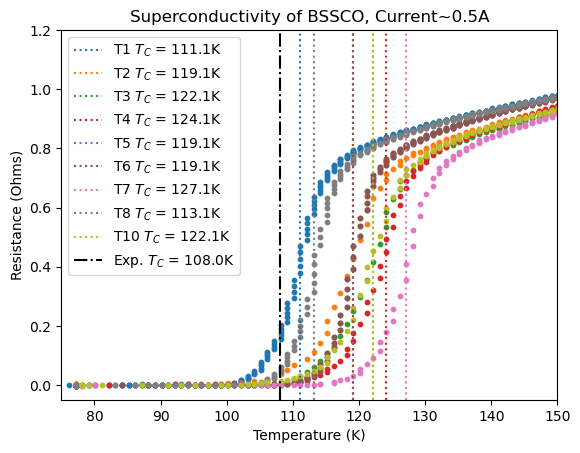

In [13]:
res = []
trials = ['t1.txt', 't2.txt', 't3.txt', 't4.txt', 't5.txt', 't6.txt', 'd3t7.txt', 'd3t8.txt', 'd3t10.txt']
for trial in trials:
    res.append(analyze(trial))
# analyze('t1.txt', granularity=3)
# analyze('t2.txt')
# analyze('t3.txt', current=0.503)
# analyze('t4.txt', current=0.503)
# analyze('t5.txt')
# analyze('t6.txt')
# analyze('d3t7.txt')
# analyze('d3t8.txt', current=0.5)
# analyze('d3t10.txt', current=0.502)

print(f'<Median T_c is: {np.median(res):.2f}K>')
print()
# ERROR OF Temp ~ ThermR = 0.003 .57/1 = x/0.003

# Plot expected
Expected_Tc = 108
print(f'Expected T_c is {Expected_Tc:.1f}K')
plt.axvline(Expected_Tc, color='black', linestyle='-.', label=f'Exp. $T_C$ = {Expected_Tc:.1f}K')

plt.legend()
plt.title('Superconductivity of BSSCO, Current~0.5A')
plt.xlabel('Temperature (K)')
plt.ylabel('Resistance (Ohms)')
plt.xlim(75, 150)
plt.ylim(-0.05, 1.2)

TRIAL 9: Superconducting temperature derived from max gradient is 109.1 K (1.06%)
TRIAL 11: Superconducting temperature derived from max gradient is 116.1 K (7.55%)
TRIAL 12: Superconducting temperature derived from max gradient is 121.1 K (12.18%)
Expected Critical T_c is 108.0K


(70.0, 150.0)

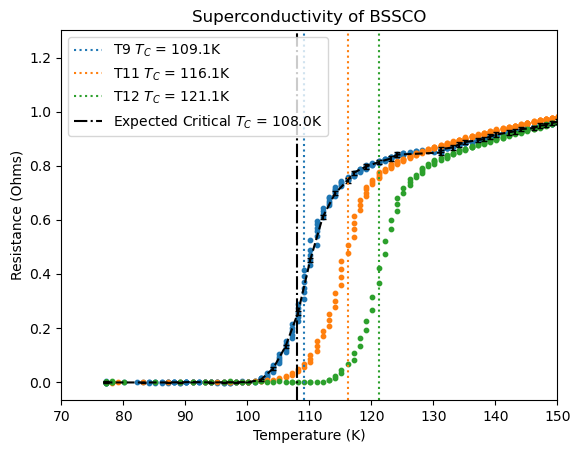

In [14]:
# Current not 0.25
analyze('d3t9.txt', current=0.25, error=True)
analyze('d3t11.txt', current=0.75)
analyze('d3t12.txt', current=0.251)

# Plot expected
Expected_Tc = 108
print(f'Expected Critical T_c is {Expected_Tc:.1f}K')
plt.axvline(Expected_Tc, color='black', linestyle='-.', label=f'Expected Critical $T_C$ = {Expected_Tc:.1f}K')

plt.legend()
plt.title('Superconductivity of BSSCO')
plt.xlabel('Temperature (K)')
plt.ylabel('Resistance (Ohms)')
plt.xlim(70, 150)